In [1]:
import os
import numpy as np
import scipy
import scipy.linalg

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
datadir = "../data"


weights_file = os.path.join(datadir, "DHFR.weights.npy")

if os.path.isfile(weights_file):
    weights = np.load(weights_file)
    print("Loading weights from : ", weights_file)

single_site_marginal_file = os.path.join(datadir, "DHFR.single.npy")
double_site_marginal_file = os.path.join(datadir, "DHFR.double.npy")

if os.path.isfile(double_site_marginal_file) and os.path.isfile(single_site_marginal_file):
    f_i_a = np.load(single_site_marginal_file)
    print("Loading single site marginals from ", single_site_marginal_file)

    f_i_j_a_b = np.load(double_site_marginal_file)
    print("Loading double site marginals from ", double_site_marginal_file)    

Loading weights from :  ../data/DHFR.weights.npy
Loading single site marginals from  ../data/DHFR.single.npy
Loading double site marginals from  ../data/DHFR.double.npy


In [3]:
AMINO_ACIDS = np.array([aa for aa in "RKDEQNHSTCYWAILMFVPG-"], "S1")

In [4]:
L, q = f_i_a.shape

M_eff = sum(weights)

In [5]:
# Add pseudo count
pseudo_count_ratio = 0.03

f_i_a = (pseudo_count_ratio / q ) + (1 - pseudo_count_ratio) * f_i_a / M_eff
f_i_j_a_b = (pseudo_count_ratio  / (q*q) ) + (1 - pseudo_count_ratio) * f_i_j_a_b / M_eff

# The formula for f_i_j_a_b is a little different when i==j
# essentially we have f_i_a on the diagonal and zero's everywhere else. 
for i in range(L):
    f_i_j_a_b[i, :, i, :] = np.diag(f_i_a[i, :])

In [6]:
phi_i_a = np.log(f_i_a[:, :(q-1)] / (1.0 - f_i_a[:, :(q-1)]) * ((1-0.05) / 0.05))

In [7]:
# Covariance Matrix
# We take an outer product of f_i_a with itself using numpy's broadcasting rules. 
# This gives us a matrix where the (i,a, j, b) index is f[i,a] * f[j,b]
C_i_j_a_b = f_i_j_a_b  - f_i_a[:, :, np.newaxis, np.newaxis] * f_i_a[np.newaxis, np.newaxis, :, :] 

# we project the covariance matrix down the first q-1 elements
# Since the frequencies add up to 1 we can discard amino-acid value (a = q) for each site
# without losing any information
C_i_j_a_b = C_i_j_a_b[:, :(q-1), :, :(q-1)]
print("C_i_j_a_b.shape = {}".format(C_i_j_a_b.shape)) 

# delete the frequency matrices now that we have a covariance matrix.
#del f_i_a, f_i_j_a_b

C_i_j_a_b.shape = (186, 20, 186, 20)


In [8]:
Ctilde_i_j_a_b = (phi_i_a[np.newaxis, np.newaxis, :, :] * phi_i_a[:, :, np.newaxis, np.newaxis]) * C_i_j_a_b

In [9]:
C_i_j = np.linalg.norm(Ctilde_i_j_a_b, ord='fro', axis=(1,3))

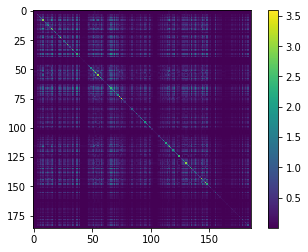

In [10]:
plt.imshow(C_i_j, cmap='viridis')
plt.colorbar()

In [11]:
evals, evecs = np.linalg.eigh(C_i_j)

Text(0, 0.5, 'Count')

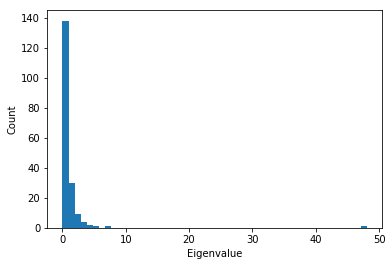

In [12]:
_ = plt.hist(evals, 50)
plt.xlabel("Eigenvalue")
plt.ylabel("Count")

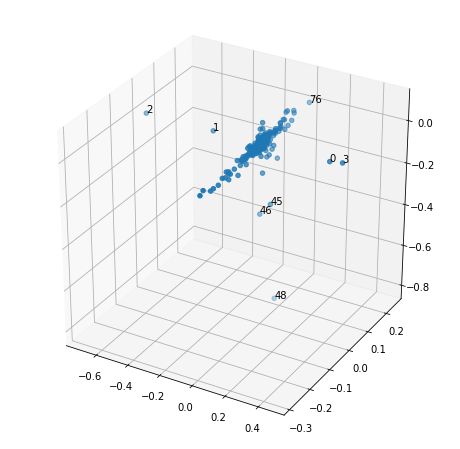

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
x, y, z = evecs[-2, :], evecs[-3, :], evecs[-4,:]
ax.scatter(x, y, z )

for i in range(x.size):
    if x[i] > 0.2 or y[i] > 0.18 or x[i] < -0.1 or z[i] < -0.2:
        ax.text(x[i], y[i], z[i], '{0}'.format(i), size=10)
